In [112]:
import numpy as np
import scipy


def cauchy_point(B,g,Delta):
    ng = np.linalg.norm(g)
    ps = -g*Delta/ng
    aux = np.dot(g,B @ g)
    if( aux <= 0 ):
        p = ps
    else:
        a = np.minimum(ng**3/(Delta*aux),1)
        p = ps*a
    return p


def _trust_region(func,grad,hess,x,method='newton',max_iter=200,tol=1e-6,callback=None):
    # parameters for trust region
    Delta_max = 5 # the max trust-region radius
    Delta_min = 1e-12 # the minimal trust-region radius
    Delta = 1 # the initial radius
    eta = 0.1 # step rejection parameter
    subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
    tol_sub = 1e-1 # relative tolerance for the subproblem
    rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
    rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius
    # initialization
    f = func(x)
    g = grad(x)
    norm_g = np.linalg.norm(g)
    print("Initially, f = ",f,", ||grad f|| = ",norm_g)

    fvals = []
    fvals.append(f)
    ngvals = []
    ngvals.append(norm_g)
    Delta = 1 # the initial trust region radius
    I = np.eye(np.size(x),dtype = float)
    iter = 1
    if method == "bfgs":
        B = I
    # the main trust-region cycle
    while (norm_g > tol and iter < max_iter):
        # solve the constrained minimization problem
        if method == "newton":
            B = hess(x)
            p, flag_boundary = _exact_subproblem(B,g,Delta,subproblem_iter_max,tol_sub)
        if method == "bfgs":
            p, flag_boundary = _dogleg_subproblem(B,g,Delta,)
        # assess the progress
        xnew = x + p
        fnew = func(xnew)
        if method == 'bfgs':
            s = xnew - x
            ys = fnew - f
            B = B + np.outer(f, f) / ys - B @ np.outer(s, s) @ B / (s @ B @ s)
        gnew = grad(xnew)
        mnew = f + np.dot(g,p) + 0.5*np.dot(p,B @ p)
        rho = (f - fnew)/(f - mnew+1e-14)
        # adjust the trust region
        if( rho < rho_bad ):
            Delta = np.maximum(0.25*Delta,Delta_min)
        elif(  rho > rho_good and flag_boundary == 1 ):
            Delta = np.minimum(Delta_max,2*Delta)
        # accept or reject step
        if( rho > eta ):  # accept step
            x = xnew
            f = fnew
            g = gnew
            norm_g = np.linalg.norm(g)
            # print(f'Accept: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
        else:
            pass
            # print(f'Reject: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
        if callback is not None:
            callback(x=x, f=f, g_new=g, iter=iter,a=np.linalg.norm(p))

        fvals.append(f)
        ngvals.append(norm_g)
        iter = iter + 1
    return x,fvals,ngvals

def _dogleg_subproblem(B,g,Delta,subproblem_iter_max,tol_sub):

    return

def _exact_subproblem(B,g,Delta,subproblem_iter_max,tol_sub):
    flag_boundary = 0
    eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
    j_sub = 0
    if( eval_min > 0 ): # B is SPD: B = R'*R, R'*R*p = -g
        p = scipy.linalg.solve(B,-g)
        p_norm = np.linalg.norm(p)
        if( p_norm > Delta ): # else: we are done with solbing the subproblem
            flag_boundary = 1
    else:
        flag_boundary = 1
    if( flag_boundary == 1 ): # solution lies on the boundary
        lam_min = np.maximum(-eval_min,0.0)
        lam = lam_min + 1
        R = scipy.linalg.cholesky(B+lam*np.eye(B.shape[0]),lower = False)
        flag_subproblem_success = 0
        while( j_sub < subproblem_iter_max ):
            j_sub = j_sub + 1
            p = scipy.linalg.solve_triangular(np.transpose(R),-g,lower = True)
            p = scipy.linalg.solve_triangular(R,p,lower = False)
            p_norm = np.linalg.norm(p)
            dd = np.absolute(p_norm - Delta)
            if( dd < tol_sub*Delta ):
                flag_subproblem_success = 1
                break
            q = scipy.linalg.solve_triangular(np.transpose(R),p,lower = True)
            q_norm = np.linalg.norm(q)
            dlam = ((p_norm/q_norm)**2)*(p_norm - Delta)/Delta
            lam_new = lam + dlam
            if (lam_new > lam_min):
                lam = lam_new
            else:
                lam = 0.5*(lam + lam_min)
            R = scipy.linalg.cholesky(B+lam*np.eye(B.shape[0]),lower = False)
        if( flag_subproblem_success == 0 ):
            p = cauchy_point(B,g,Delta)
    return p, flag_boundary


In [228]:
import numpy as np
import scipy

def cauchy_point(B, g, Delta):
    ng = np.linalg.norm(g)
    ps = -g * Delta / ng
    aux = np.dot(g, B @ g)
    if aux <= 0:
        p = ps
    else:
        a = np.minimum(ng ** 3 / (Delta * aux), 1)
        p = ps * a
    return p

def _trust_region(func, grad, hess, x, method='newton', max_iter=200, tol=1e-6, callback=None,Delta_init=1):
    # parameters for trust region
    Delta_max = 5  # the max trust-region radius
    Delta_min = 1e-12  # the minimal trust-region radius
    Delta = Delta_init  # the initial radius
    eta = 0.1  # step rejection parameter
    subproblem_iter_max = 5  # the max # of iteration for quadratic subproblems
    tol_sub = 1e-1  # relative tolerance for the subproblem
    rho_good = 0.75  # if rho > rho_good, increase the trust-region radius
    rho_bad = 0.25  # if rho < rho_bad, decrease the trust-region radius

    # initialization
    f = func(x)
    g = grad(x)
    norm_g = np.linalg.norm(g)
    print("Initially, f =", f, ", ||grad f|| =", norm_g)

    fvals = [f]
    ngvals = [norm_g]
    I = np.eye(np.size(x), dtype=float)
    iter = 1
    if method == "bfgs":
        B = I

    # the main trust-region cycle
    while norm_g > tol and iter < max_iter:
        # solve the constrained minimization problem
        if method == "newton":
            B = hess(x)
            p, flag_boundary = _exact_subproblem(B, g, Delta, subproblem_iter_max, tol_sub)
        elif method == "bfgs":
            p, flag_boundary = _dogleg_subproblem(B, g, Delta, subproblem_iter_max, tol_sub)

        # assess the progress
        xnew = x + p
        fnew = func(xnew)
        gnew = grad(xnew)


        if method == 'bfgs':
            s = xnew - x
            y = gnew - g
            sy = np.dot(s, y)
            if sy > 1e-10:  # update only if s^T y is sufficiently positive to avoid division issues
                Bs = B @ s
                B = B + np.outer(y, y) / sy - np.outer(Bs, Bs) / np.dot(s, Bs)

        mnew = f + np.dot(g, p) + 0.5 * np.dot(p, B @ p)
        rho = (f - fnew) / (f - mnew + 1e-14)

        # adjust the trust region
        if rho < rho_bad:
            Delta = np.maximum(0.25 * Delta, Delta_min)
        elif rho > rho_good and flag_boundary == 1:
            Delta = np.minimum(Delta_max, 2 * Delta)

        # accept or reject step
        if rho > eta:  # accept step
            x = xnew
            f = fnew
            g = gnew
            norm_g = np.linalg.norm(g)

        if callback is not None:
            callback(x=x, f=f, g_new=g, iter=iter, a=np.linalg.norm(p))

        fvals.append(f)
        ngvals.append(norm_g)
        iter += 1

    return x, fvals, ngvals

def _dogleg_subproblem(B, g, Delta, subproblem_iter_max, tol_sub):
    # Step 1: Calculate the steepest descent direction (Cauchy point)
    ng = np.linalg.norm(g)
    p_u = cauchy_point(B,g,Delta)
    
    # Step 2: Calculate the Newton direction
    spd = np.all(np.linalg.eigvals(B) > 0)
    if spd:
        p_b = np.linalg.solve(B, -g)  # Newton point (trust-region center)
    else:
        # If B is not invertible, fall back to gradient direction
        p_b = -Delta * g / ng

    # Step 3: Check if the Newton step is within the trust region
    if np.linalg.norm(p_b) <= Delta:
        return p_b, 0  # Newton step is within the boundary, so return it directly

    # Step 4: Determine if the Cauchy point is within the trust region
    if np.linalg.norm(p_u) > Delta:
        # If the Cauchy point is on the boundary, we scale it to the boundary
        return (Delta / ng) * -g, 1

    # Step 5: If neither step is feasible, interpolate between p_u and p_b
    p_b_minus_p_u = p_b - p_u
    a = np.dot(p_b_minus_p_u, p_b_minus_p_u)
    b = 2 * np.dot(p_u, p_b_minus_p_u)
    c = np.dot(p_u, p_u) - Delta**2
    tau = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)

    # Compute the dogleg step on the boundary
    p = p_u + tau * (p_b - p_u)
    return p, 0  # return the boundary step with flag_boundary set to 1

def _exact_subproblem(B, g, Delta, subproblem_iter_max, tol_sub):
    flag_boundary = 0
    eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
    j_sub = 0
    if eval_min > 0:  # B is SPD: B = R'*R, R'*R*p = -g
        p = scipy.linalg.solve(B, -g)
        p_norm = np.linalg.norm(p)
        if p_norm > Delta:  # solution lies on the boundary
            flag_boundary = 1
    else:
        flag_boundary = 1

    if flag_boundary == 1:  # Boundary solution
        lam_min = max(-eval_min, 0.0)
        lam = lam_min + 1
        R = scipy.linalg.cholesky(B + lam * np.eye(B.shape[0]), lower=False)
        flag_subproblem_success = 0
        while j_sub < subproblem_iter_max:
            j_sub += 1
            p = scipy.linalg.solve_triangular(R.T, -g, lower=True)
            p = scipy.linalg.solve_triangular(R, p, lower=False)
            p_norm = np.linalg.norm(p)
            if abs(p_norm - Delta) < tol_sub * Delta:
                flag_subproblem_success = 1
                break
            q = scipy.linalg.solve_triangular(R.T, p, lower=True)
            q_norm = np.linalg.norm(q)
            dlam = (p_norm / q_norm) ** 2 * (p_norm - Delta) / Delta
            lam_new = lam + dlam
            lam = lam_new if lam_new > lam_min else 0.5 * (lam + lam_min)
            R = scipy.linalg.cholesky(B + lam * np.eye(B.shape[0]), lower=False)
        if not flag_subproblem_success:
            p = cauchy_point(B, g, Delta)
    return p, flag_boundary


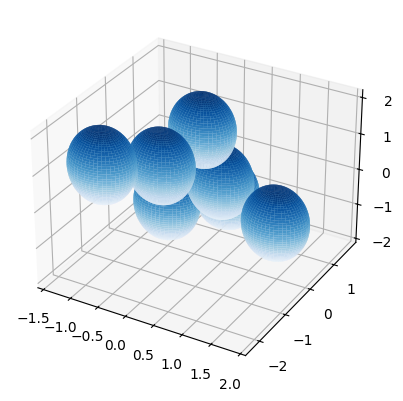

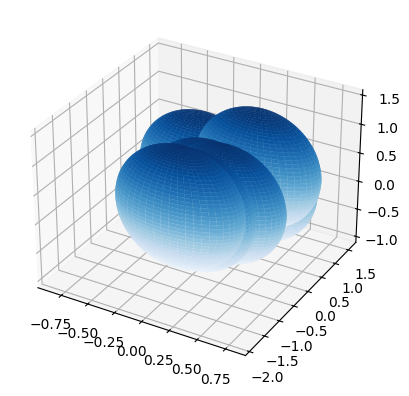

LJpot =  75248140797.16135


In [140]:
from LJhelpers import *
Na = 7 #the number of atoms
rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
tol = 1e-9 # stop iterations when ||grad f|| < tol
iter_max = 1000 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
# parameters for backtracking line search
c = 0.1;
rho = 0.9;

model = 0
if( model > 0):
    Na = 7
xyz = initial_configuration(model,Na,rstar)
drawconf(xyz,0.5*rstar);

x0 = remove_rotations_translations(xyz)
drawconf(LJvector2array(x0),0.5*rstar)
print("LJpot = ",LJpot(x0))
# print(LJhess(x))



In [240]:
import matplotlib.pyplot as plt

fvalss = {}
ngvalss = {}

for method in ["newton","bfgs"]:
    fvalss[method] = {}
    ngvalss[method] = {}
    xyzs = [initial_configuration(model,Na,rstar) for model in range(1,5)] 
    for _ in range(10):
        xyzs.append(initial_configuration(5,Na,rstar))
    confs = list(range(1,5))+[f'rand{i}' for i in range(10)]

    x0s = [remove_rotations_translations(xyz) for xyz in xyzs]
    for conf,x0 in zip(confs,x0s):
        xopt,fvals,ngvals = _trust_region(LJpot, LJgrad, LJhess, x0,method=method,max_iter=1000,Delta_init=2)
        print("Optimization result:", xopt)
        fvalss[method][conf] = fvals
        ngvalss[method][conf] = ngvals

Initially, f = -11.517662869490488 , ||grad f|| = 16.468632904952266
Optimization result: [ 1.12408793e+00  1.47145021e+00  1.06907115e+00  5.62043966e-01
  1.72979346e+00  1.57414648e-15 -3.47362275e-01  1.06907115e+00
  9.89116212e-16  5.62043967e-01  7.73587154e-01  5.73870169e-01
  5.62043967e-01  7.73587154e-01 -5.73870169e-01]
Initially, f = -15.921231995884773 , ||grad f|| = 2.1196800775302633
Optimization result: [ 1.11959051e+00  1.11850571e+00  1.11536611e+00  1.08479969e-03
  1.11536611e+00  3.03196874e-11  5.59795257e-01  5.61371003e-01
  7.90553468e-01  5.59795257e-01  5.55082963e-01 -7.89021494e-01
  5.59795257e-01 -5.56644359e-01  7.91666544e-01]
Initially, f = -15.581469160072078 , ||grad f|| = 1.4608366392938117
Optimization result: [ 1.1187935   0.55939675  0.96890359  0.55939675 -0.74773545  0.61550284
  1.48665302  0.85831952  0.61550284 -0.36785952  0.85831952  0.61550284
  0.55939675  0.32296786  0.92200413]
Initially, f = -15.522210169999571 , ||grad f|| = 1.2854

newton
bfgs


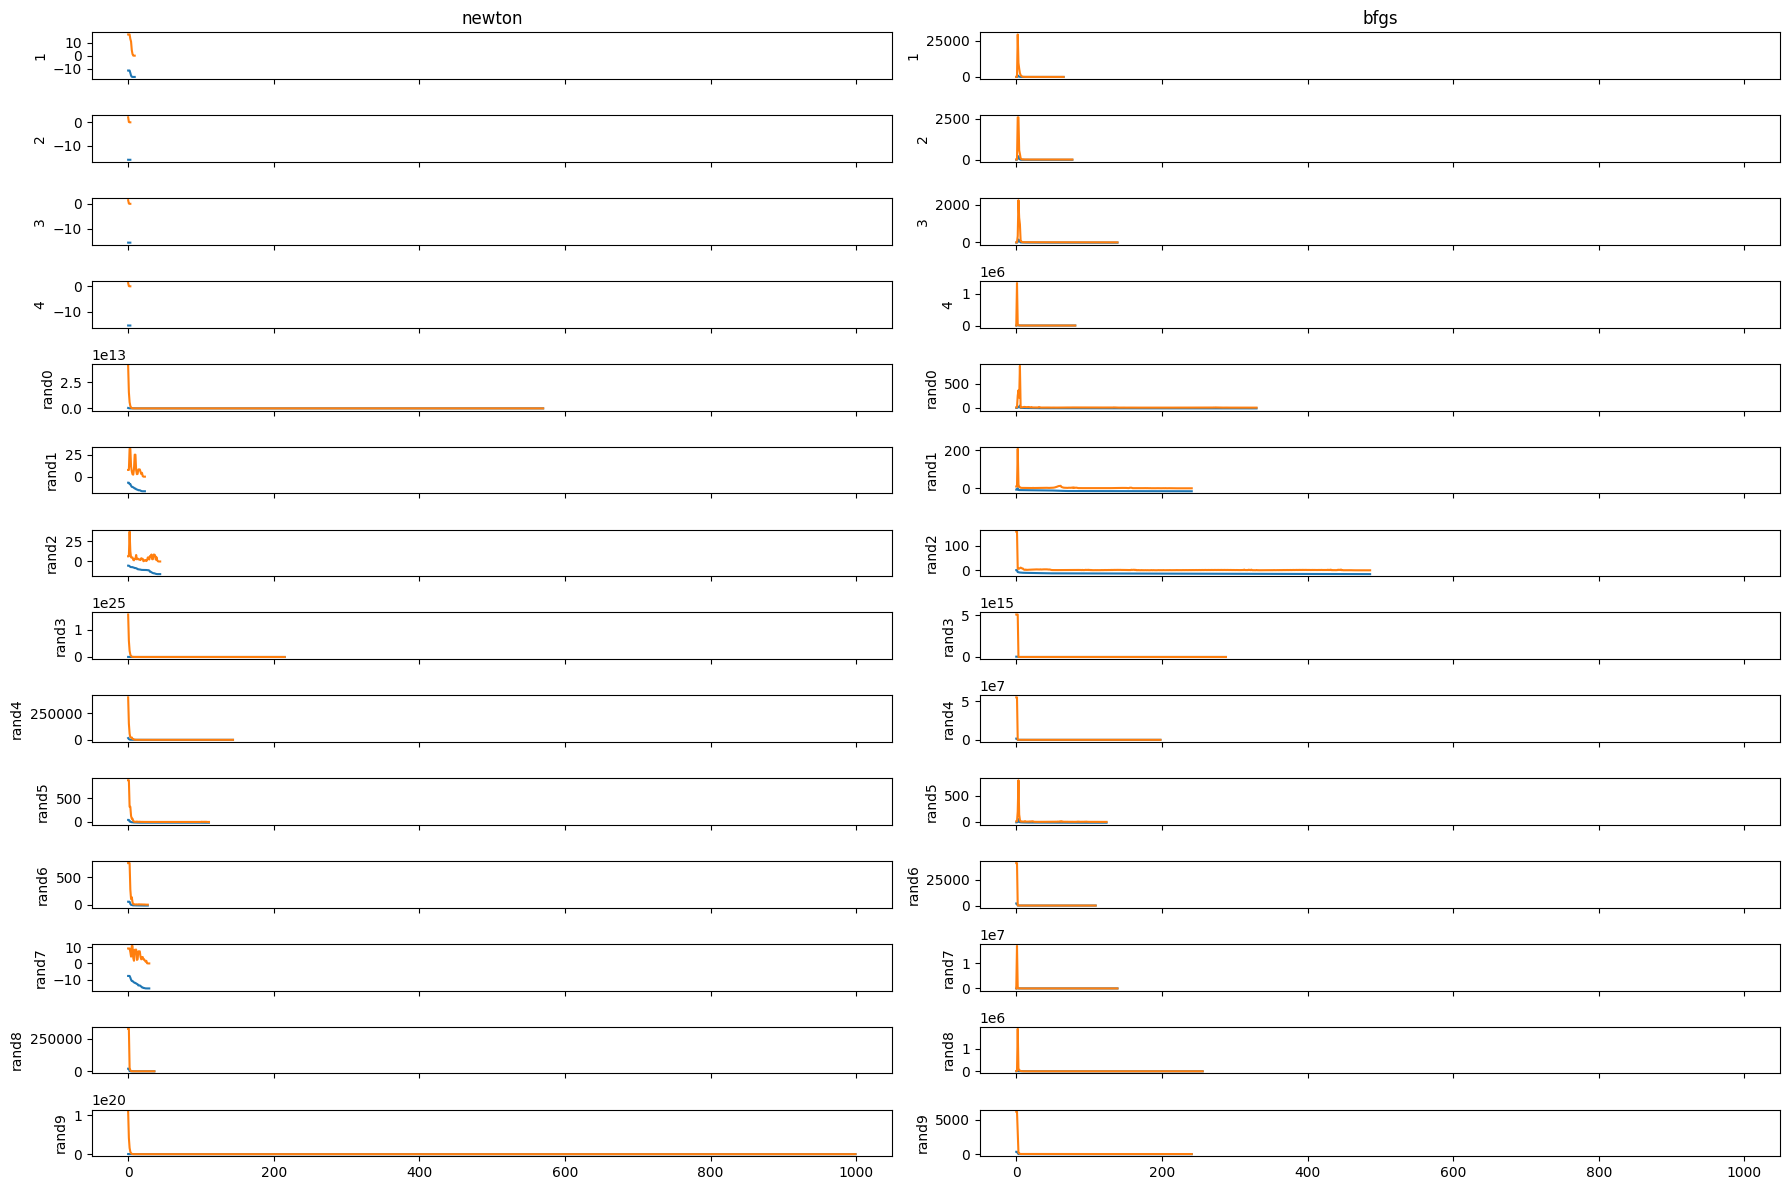

In [241]:
fig,ax = plt.subplots(len(confs),2,figsize = (18,12), sharex=True)
for i,method in enumerate(list(fvalss.keys())):
    print(method)
    ax[0,i].set_title(f'{method}')
    for j,conf in enumerate(list(fvalss[method].keys())):
        
        # print(conf)
        ax[j,i].set_ylabel(f'{conf}')
        ax[j,i].plot(fvalss[method][conf])
        ax[j,i].plot(ngvalss[method][conf])

plt.tight_layout()
plt.show()
#         ax[i].plot(fvals)
# ax[0].plot(fvals)
# ax[1].plot(ngvals)


In [255]:
import numpy as np

# Define the quadratic function, gradient, and Hessian
a = 1
b = 100

# Define the Rosenbrock function, its gradient, and Hessian
def func(x):
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2

def grad(x):
    df_dx = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0] ** 2)
    df_dy = 2 * b * (x[1] - x[0] ** 2)
    return np.array([df_dx, df_dy])

def hess(x):
    d2f_dx2 = 2 - 4 * b * (x[1] - x[0] ** 2) + 8 * b * x[0] ** 2
    d2f_dxdy = -4 * b * x[0]
    d2f_dy2 = 2 * b
    return np.array([[d2f_dx2, d2f_dxdy],
                     [d2f_dxdy, d2f_dy2]])


# x0 = np.array([1.2, 1.2])
# x0 = np.array([-1.2, 1.0])
x0s = [np.array([1.2, 1.2]),np.array([-1.2, 1.0])]
xk = {}
ak = {}
for i,x0 in enumerate(x0s):
    xk[i] = {}
    ak[i] = {}
    for method in ['newton','bfgs']:
        xk[i][method] = []
        ak[i][method] = []
        # xopt,fvals,ngvals = _line_search(func, grad, hess, x0,direction=2)
        
        def callback(**kwargs):
            x = kwargs['x']
            a = kwargs['a']
            xk[i][method].append(x)
            ak[i][method].append(a)
        xopt,fvals,ngvals = _trust_region(func, grad, hess, x0,method=method,callback=callback,max_iter=200,Delta_init=.125)
        
        # Output final results
        print("Optimization result:", xopt)
    #     import matplotlib.pyplot as plt
    #     ax[i].set_title(f'x0 = {x0}')
    #     l, = ax[i].plot(np.linalg.norm(xk[i][direction]-xopt_true, axis=1))
    #     l.set_label(f'direction = {direction}')
    # ax[i].set_yscale('log')
# fig.legend()
# plt.show()

Initially, f = 5.8 , ||grad f|| = 125.16932531574977
Optimization result: [1. 1.]
Initially, f = 5.8 , ||grad f|| = 125.16932531574977
Optimization result: [1.00000001 1.00000002]
Initially, f = 24.199999999999996 , ||grad f|| = 232.86768775422664
Optimization result: [1. 1.]
Initially, f = 24.199999999999996 , ||grad f|| = 232.86768775422664
Optimization result: [1. 1.]


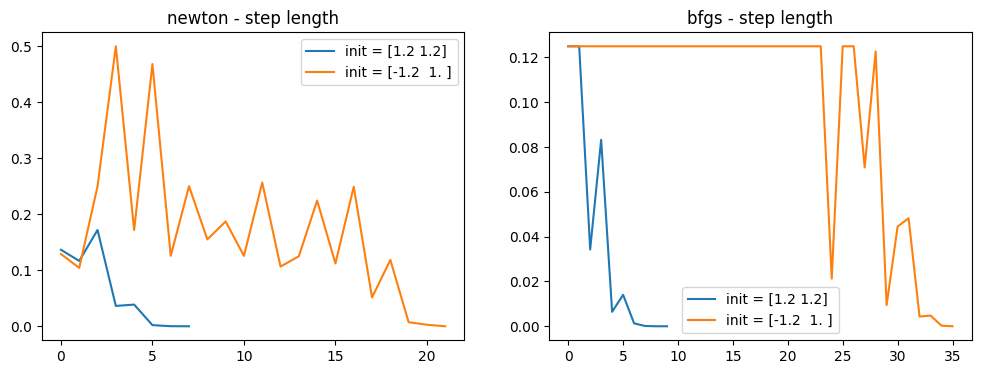

In [256]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
xopt_true = np.array([1.0,1.0])
x0s = [np.array([1.2, 1.2]),np.array([-1.2, 1.0])]
# method_dict = {0:'SD',1:'Newton',2:'BFGS'}
for j,method in enumerate(['newton','bfgs']):
    for i,x0 in enumerate(x0s):
        ax[j].set_title(f"{method} - step length")
        l, = ax[j].plot(ak[i][method])
        l.set_label(f'init = {x0}')
        ax[j].legend()

# fig.legend()
plt.show()

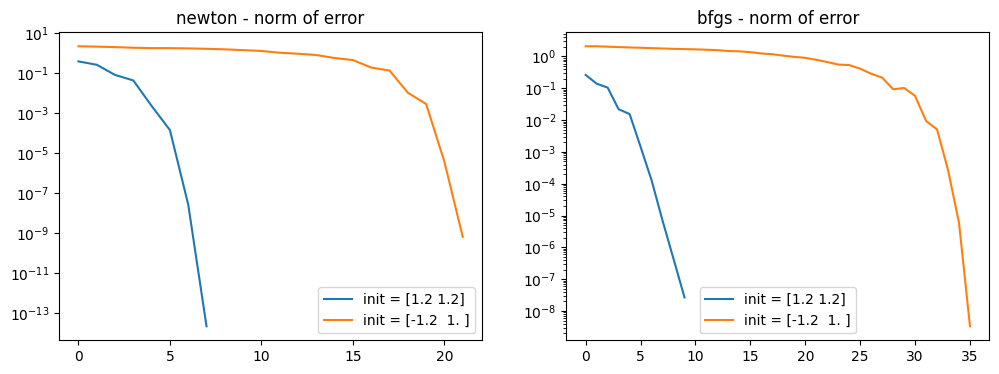

In [257]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
xopt_true = np.array([1.0,1.0])
x0s = [np.array([1.2, 1.2]),np.array([-1.2, 1.0])]
for j,method in enumerate(['newton','bfgs']):
    for i,x0 in enumerate(x0s):
        ax[j].set_title(f"{method} - norm of error")
        l, = ax[j].plot(np.linalg.norm(xk[i][method]-xopt_true, axis=1))
        l.set_label(f'init = {x0}')
        ax[j].set_yscale('log')
        ax[j].legend()

# fig.legend()
plt.show()


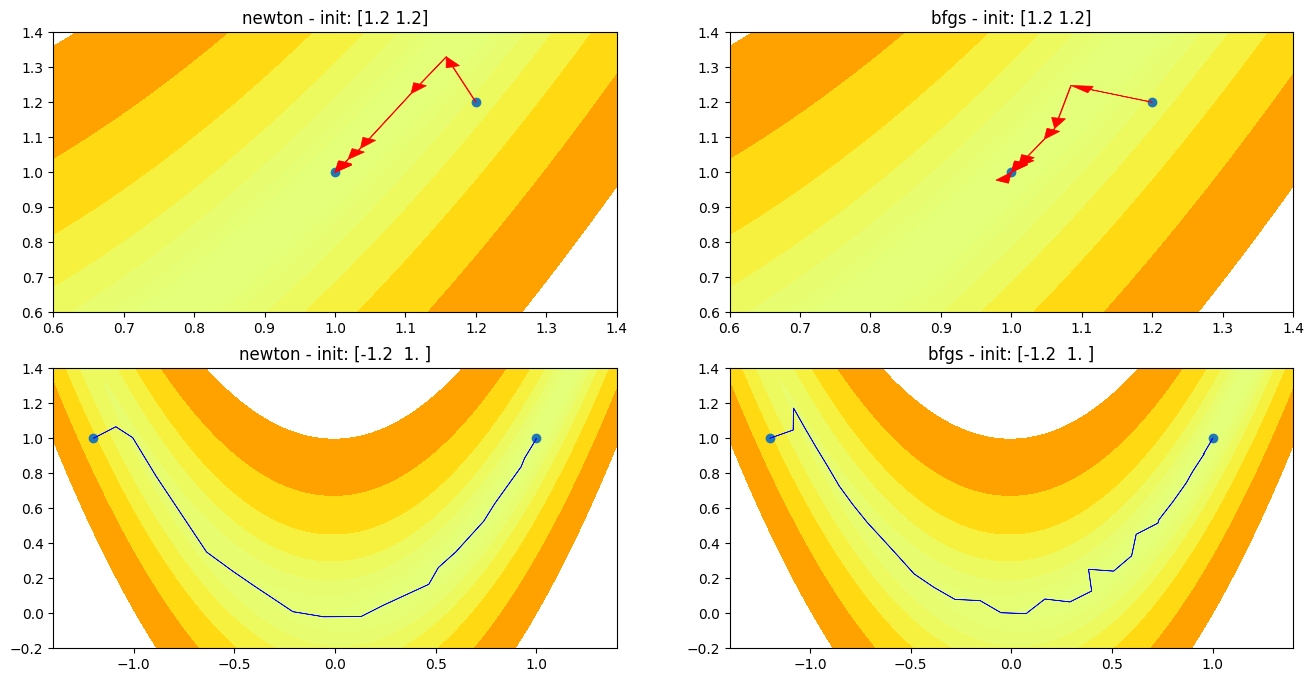

In [258]:


fig, ax = plt.subplots(2,2,figsize=(16,8))
# plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap="viridis")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Optimization Paths on Rosenbrock Function")

xopt_true = np.array([1.0,1.0])
x0s = [np.array([1.2, 1.2]),np.array([-1.2, 1.0])]
colors = ["red", "blue",]
for k,method in enumerate(['newton','bfgs',]):
    for i,x0 in enumerate(x0s):
        ax[i][k].set_title(f"{method} - init: {x0}")
        if i == 0:
            x_vals = np.linspace(.6, 1.4, 400)
            y_vals = np.linspace(.6, 1.4, 400)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = func([X,Y])
        else:
            x_vals = np.linspace(-1.4, 1.4, 400)
            y_vals = np.linspace(-.2, 1.4, 400)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = func([X,Y])
        ax[i][k].contourf(X, Y, Z, levels=np.logspace(-3, 2, 16), cmap="Wistia")
        points = np.array(xk[i][method])
        points = np.concatenate([[x0],points],axis=0)
        
        ax[i][k].scatter([x0[0],xopt_true[0]],[x0[1],xopt_true[1]])
        for j in range(len(points) - 1):
            ax[i][k].arrow(points[j, 0], points[j, 1],
                    points[j+1, 0] - points[j, 0], points[j+1, 1] - points[j, 1],
                    color=colors[i], shape='full', lw=.5, length_includes_head=True, head_width=np.mean(x_vals)/50)
# x0 = np.array([-1.2, 1.0])

# # Run line search with different methods and plot their paths
# methods = ["Steepest Descent", "Newton", "BFGS"]
# colors = ["red", "blue", "green"]
# for i, method in enumerate(methods):
#     points = np.array(xk[1][i])
#     plt.plot(points[:, 0], points[:, 1], 'o-', color=colors[i], label=method)

# plt.legend()
# plt.show()